In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB :
  %load_ext autoreload
  %autoreload 2
  
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github

  repository= 'keyword_spotting'
  %cd {repository}
  %ls -a
  # CPU:
  #!pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

  # GPU:
  !pip install pydub torch==1.11.0+cu115 torchvision==0.12.0+cu115 torchaudio==0.11.0 -f https://download.pytorch.org/whl/torch_stable.html

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive
/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/keyword_spotting
dataset/  main.py   models/     __pycache__/  SpeechCommands/
.git/     metrics/  notebooks/  README.md     utilsFunc.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████▌                   | 834.1 MB 1.4 MB/s eta 0:15:30tcmalloc: large alloc 1147494400 bytes == 0x3a718000 @  0x7f5f5d8e4615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███████████████▉                | 1055.7 MB 1.3 MB/s eta 0:13:32tcmalloc: large alloc 1434370048 bytes =

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio,torchvision
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import metrics.metrics as metrics
from dataset.subsetSC import SubsetSC
from models.mel_model import mel_model
from utilsFunc import *

working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()

In [3]:
storage['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using',storage['device'])


PATH='MelSpectr.pt'
storage['training_mode']=True

Using cuda


## Downloading and setting up the dataset

In [4]:
with timeThat('training & test sets'):
    root='/content/sample_data' if IN_COLAB else './'
    if 'train_set' not in locals():  
        train_set = SubsetSC("training",root)
    if 'test_set' not in locals():
        test_set = SubsetSC("testing",root)
storage['waveform'], storage['sample_rate'], label, speaker_id, utterance_number = train_set[0]

# TODO : We are doing it without resampling it.
#resample_transform=torchaudio.transforms.Resample(orig_freq=storage['sample_rate'], new_freq=new_sample_rate)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

training & test sets finished in  0:01:55.187727


## Let's visualize the data !

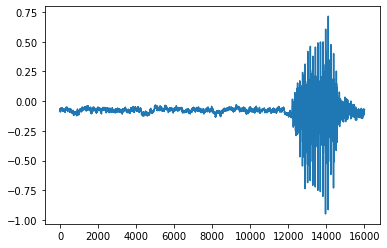

In [5]:
plt.plot(storage['waveform'].t().numpy())

(241, 98)


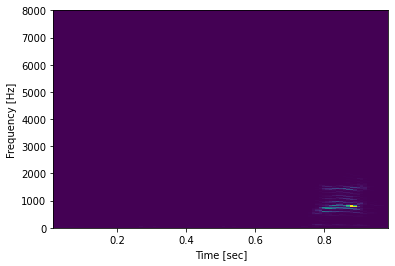

In [6]:
from scipy import signal
from scipy.fft import fftshift

fe=16000
noverlap=int(20e-3*fe)
nperseg=int(30e-3*fe)
f, t, Sxx = signal.spectrogram(storage['waveform'][0], fe,noverlap=noverlap,nperseg=nperseg)
plt.pcolormesh(t, f, Sxx)
print(Sxx.shape)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [7]:

n_mels=50

win_length=int(30e-3 *fe)
hop_length=int(10e-3 *fe)
n_fft=win_length 
spec_size=(fe -win_length)/hop_length +1
print('size of tensor should be ',spec_size)

size of tensor should be  98.0


### Mel's spectrogram

Shape of spectrogram: torch.Size([1, 50, 101])


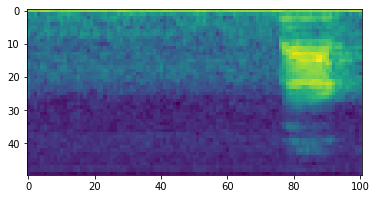

In [8]:
mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(n_fft=n_fft,
                                        n_mels=n_mels,win_length=win_length,hop_length=hop_length)
spectrogram_spec=mel_spectrogram_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(spectrogram_spec.size()))

plt.figure()
p = plt.imshow(spectrogram_spec.log2()[0].detach().numpy())

### MFCC

Shape of spectrogram: torch.Size([1, 40, 101])


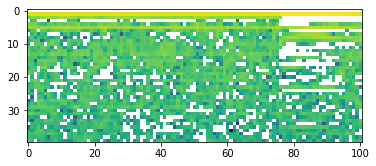

In [9]:
MFCC_transform = torchaudio.transforms.MFCC(melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    })
MFCC_spec=MFCC_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(MFCC_spec.size()))

plt.figure()
p = plt.imshow(MFCC_spec.log2()[0].detach().numpy())

## Resampling the data and setting the transform

In [10]:
layers =[]
layers.append(MFCC_transform)

storage['transform'] = nn.Sequential(*layers)

waveform_size=storage['transform'](storage['waveform']).shape
print(waveform_size)

torch.Size([1, 40, 101])


## Setting up the test and train loader

In [11]:
batch_size = 100

if storage['device'] == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
    
storage['train_loader']  = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=train_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
storage['test_loader']  = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=test_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the network

In [12]:
storage['model'] = mel_model(input_shape=waveform_size, n_output=len(train_set.labels))
storage['model'].to(storage['device'])
#print(storage['model'])
print("Number of parameters: %s" % storage['model'].count_parameters())

Number of parameters: 355011


## Define the optimizer, loss function & metrics

In [13]:
# Define the Optimizer
lr=0.001 
storage['optimizer'] = optim.Adam(storage['model'].parameters(), lr=lr, weight_decay=0.0001)
storage['scheduler'] = optim.lr_scheduler.StepLR(storage['optimizer'], step_size=20,
                                      gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10
#Define the loss Function
storage['lossFunc']=F.cross_entropy
#Define the metrics :
storage['metrics']=metrics.countCorrectOutput

## Define the log interval and epochs

In [14]:
storage['log_interval'] = 20
storage['n_epoch'] = 20

storage['pbar_update']  = 1 / (len(storage['train_loader']) + len(storage['test_loader']))
storage['losses'] = []
# The transform needs to live on the same device as the model and the data.

storage['transform'] = storage['transform'].to(storage['device'])

## Train and testing

In [15]:
with timeThat('Main program') :
    with tqdm(total=storage['n_epoch']) as pbar:
        storage['pbar']=pbar
        for epoch in range(1, storage['n_epoch'] + 1):
            storage['epoch']=epoch
            train(storage)
            test(storage)
            storage['scheduler'].step()

  0%|          | 0.0020833333333333333/20 [00:07<15:29:57, 2790.18s/it]

Train Epoch: 20 [0/84843 (0%)]	Loss: 3.953404


  0%|          | 0.024999999999999998/20 [00:08<25:43, 77.26s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 3.571532


  0%|          | 0.04375000000000003/20 [00:09<21:31, 64.70s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 3.489794


  0%|          | 0.06458333333333341/20 [00:11<21:50, 65.73s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 3.546488


  0%|          | 0.0875/20 [00:12<20:45, 62.54s/it]             

Train Epoch: 20 [8000/84843 (9%)]	Loss: 3.440908


  1%|          | 0.10833333333333325/20 [00:13<21:37, 65.24s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 3.313907


  1%|          | 0.1291666666666665/20 [00:15<20:39, 62.37s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 3.318538


  1%|          | 0.14999999999999977/20 [00:16<21:44, 65.73s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 3.380294


  1%|          | 0.17083333333333303/20 [00:17<20:39, 62.53s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 3.126906


  1%|          | 0.1916666666666663/20 [00:19<21:23, 64.79s/it] 

Train Epoch: 20 [18000/84843 (21%)]	Loss: 3.097277


  1%|          | 0.21249999999999955/20 [00:20<21:17, 64.54s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 3.156458


  1%|          | 0.2333333333333328/20 [00:21<20:38, 62.67s/it] 

Train Epoch: 20 [22000/84843 (26%)]	Loss: 3.153526


  1%|▏         | 0.25208333333333277/20 [00:23<22:06, 67.16s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 3.244246


  1%|▏         | 0.27499999999999936/20 [00:24<20:46, 63.21s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 2.779569


  1%|▏         | 0.2937499999999993/20 [00:25<22:15, 67.77s/it] 

Train Epoch: 20 [28000/84843 (33%)]	Loss: 3.001685


  2%|▏         | 0.31458333333333255/20 [00:27<21:08, 64.42s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 2.955715


  2%|▏         | 0.3354166666666658/20 [00:28<21:18, 65.00s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 3.189848


  2%|▏         | 0.3583333333333324/20 [00:30<21:36, 66.02s/it] 

Train Epoch: 20 [34000/84843 (40%)]	Loss: 2.863732


  2%|▏         | 0.37916666666666565/20 [00:31<20:38, 63.12s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 2.968151


  2%|▏         | 0.3979166666666656/20 [00:32<20:17, 62.12s/it] 

Train Epoch: 20 [38000/84843 (45%)]	Loss: 2.951053


  2%|▏         | 0.42083333333333217/20 [00:34<20:57, 64.24s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 2.841160


  2%|▏         | 0.4395833333333321/20 [00:35<21:49, 66.93s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 2.947467


  2%|▏         | 0.46041666666666536/20 [00:36<21:25, 65.81s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 2.987617


  2%|▏         | 0.4812499999999986/20 [00:38<22:35, 69.44s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 3.081275


  3%|▎         | 0.502083333333332/20 [00:39<20:08, 61.97s/it]  

Train Epoch: 20 [48000/84843 (57%)]	Loss: 2.886079


  3%|▎         | 0.5229166666666664/20 [00:40<20:53, 64.36s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 2.721110


  3%|▎         | 0.5437500000000007/20 [00:42<21:50, 67.36s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 2.873302


  3%|▎         | 0.5645833333333351/20 [00:43<20:41, 63.88s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 2.806336


  3%|▎         | 0.5875000000000029/20 [00:45<20:45, 64.14s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 2.629872


  3%|▎         | 0.6062500000000038/20 [00:46<21:16, 65.81s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 2.801434


  3%|▎         | 0.6270833333333382/20 [00:47<21:50, 67.62s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 2.746153


  3%|▎         | 0.6479166666666726/20 [00:49<22:21, 69.34s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 2.895146


  3%|▎         | 0.668750000000007/20 [00:50<22:06, 68.60s/it] 

Train Epoch: 20 [64000/84843 (75%)]	Loss: 2.699675


  3%|▎         | 0.6895833333333413/20 [00:51<21:47, 67.72s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 2.591804


  4%|▎         | 0.7104166666666757/20 [00:53<21:43, 67.60s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 2.696778


  4%|▎         | 0.7333333333333435/20 [00:55<21:38, 67.38s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 2.692191


  4%|▍         | 0.7520833333333444/20 [00:56<23:05, 71.97s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 2.619986


  4%|▍         | 0.7750000000000122/20 [00:57<22:16, 69.51s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 2.411645


  4%|▍         | 0.7937500000000132/20 [00:59<24:49, 77.56s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 3.000864


  4%|▍         | 0.816666666666681/20 [01:01<22:06, 69.13s/it] 

Train Epoch: 20 [78000/84843 (92%)]	Loss: 2.502757


  4%|▍         | 0.8354166666666819/20 [01:02<22:40, 70.98s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 2.753761


  4%|▍         | 0.8562500000000163/20 [01:04<23:04, 72.33s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 2.482234


  4%|▍         | 0.8770833333333506/20 [01:05<23:03, 72.34s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 2.550353


  5%|▌         | 1.0052083333333564/20 [01:15<17:02, 53.85s/it]


Test Epoch: 20	Accuracy: 3856/11005 (35%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 2.440878


  5%|▌         | 1.027083333333355/20 [01:16<11:23, 36.02s/it] 

Train Epoch: 20 [2000/84843 (2%)]	Loss: 2.592636


  5%|▌         | 1.045833333333354/20 [01:16<11:08, 35.26s/it] 

Train Epoch: 20 [4000/84843 (5%)]	Loss: 2.599903


  5%|▌         | 1.0677083333333528/20 [01:17<11:17, 35.80s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 2.609427


  5%|▌         | 1.0895833333333516/20 [01:18<10:58, 34.84s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 2.782888


  6%|▌         | 1.1083333333333505/20 [01:19<11:09, 35.42s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 2.620324


  6%|▌         | 1.1302083333333492/20 [01:19<11:14, 35.73s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 2.649804


  6%|▌         | 1.152083333333348/20 [01:20<11:22, 36.20s/it] 

Train Epoch: 20 [14000/84843 (16%)]	Loss: 2.480561


  6%|▌         | 1.170833333333347/20 [01:21<11:04, 35.31s/it] 

Train Epoch: 20 [16000/84843 (19%)]	Loss: 2.573440


  6%|▌         | 1.1927083333333457/20 [01:22<11:04, 35.32s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 2.284292


  6%|▌         | 1.2145833333333445/20 [01:22<10:58, 35.06s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 2.503170


  6%|▌         | 1.2333333333333434/20 [01:23<10:54, 34.90s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 2.522651


  6%|▋         | 1.2552083333333421/20 [01:24<11:11, 35.83s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 2.645513


  6%|▋         | 1.277083333333341/20 [01:25<10:59, 35.25s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 2.667635


  6%|▋         | 1.2958333333333398/20 [01:25<10:58, 35.21s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 2.555428


  7%|▋         | 1.3177083333333386/20 [01:26<10:52, 34.94s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 2.559343


  7%|▋         | 1.3395833333333373/20 [01:27<10:56, 35.20s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 2.496161


  7%|▋         | 1.3583333333333363/20 [01:27<10:54, 35.11s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 2.477984


  7%|▋         | 1.380208333333335/20 [01:28<10:45, 34.69s/it] 

Train Epoch: 20 [36000/84843 (42%)]	Loss: 2.207536


  7%|▋         | 1.4020833333333338/20 [01:29<10:23, 33.52s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 2.116042


  7%|▋         | 1.4208333333333327/20 [01:30<11:19, 36.58s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 2.441337


  7%|▋         | 1.4427083333333315/20 [01:30<10:47, 34.89s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 2.531142


  7%|▋         | 1.4645833333333302/20 [01:31<10:31, 34.06s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 2.575666


  7%|▋         | 1.4833333333333292/20 [01:32<10:45, 34.89s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 2.580806


  8%|▊         | 1.505208333333328/20 [01:33<10:48, 35.07s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 2.421224


  8%|▊         | 1.5270833333333267/20 [01:33<10:45, 34.94s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 2.556728


  8%|▊         | 1.5458333333333256/20 [01:34<10:44, 34.93s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 2.117642


  8%|▊         | 1.5677083333333244/20 [01:35<10:43, 34.89s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 2.613479


  8%|▊         | 1.5895833333333231/20 [01:36<10:58, 35.78s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 2.526220


  8%|▊         | 1.608333333333322/20 [01:36<10:36, 34.60s/it] 

Train Epoch: 20 [58000/84843 (68%)]	Loss: 2.326687


  8%|▊         | 1.6302083333333208/20 [01:37<10:36, 34.62s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 2.680528


  8%|▊         | 1.6520833333333196/20 [01:38<10:37, 34.74s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 2.388793


  8%|▊         | 1.6708333333333185/20 [01:38<10:56, 35.84s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 2.355868


  8%|▊         | 1.6927083333333173/20 [01:39<10:36, 34.78s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 2.208694


  9%|▊         | 1.714583333333316/20 [01:40<10:27, 34.30s/it] 

Train Epoch: 20 [68000/84843 (80%)]	Loss: 2.514994


  9%|▊         | 1.733333333333315/20 [01:41<10:48, 35.48s/it] 

Train Epoch: 20 [70000/84843 (82%)]	Loss: 2.332979


  9%|▉         | 1.7552083333333137/20 [01:41<10:38, 34.98s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 2.585245


  9%|▉         | 1.7770833333333125/20 [01:42<10:33, 34.78s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 2.292055


  9%|▉         | 1.7958333333333114/20 [01:43<10:39, 35.15s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 2.427716


  9%|▉         | 1.8177083333333102/20 [01:44<10:43, 35.39s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 2.196031


  9%|▉         | 1.839583333333309/20 [01:44<10:31, 34.79s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 2.423676


  9%|▉         | 1.8583333333333079/20 [01:45<10:39, 35.26s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 2.434563


  9%|▉         | 1.8802083333333066/20 [01:46<10:40, 35.32s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 2.476371


 10%|█         | 2.004166666666633/20 [01:49<09:02, 30.15s/it] 


Test Epoch: 20	Accuracy: 4390/11005 (40%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 2.369307


 10%|█         | 2.026041666666632/20 [01:50<10:02, 33.54s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 2.067450


 10%|█         | 2.0479166666666306/20 [01:51<10:21, 34.63s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 2.254806


 10%|█         | 2.0666666666666296/20 [01:51<10:25, 34.88s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 2.724076


 10%|█         | 2.0885416666666283/20 [01:52<10:17, 34.50s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 2.460487


 11%|█         | 2.110416666666627/20 [01:53<10:19, 34.64s/it] 

Train Epoch: 20 [10000/84843 (12%)]	Loss: 2.397352


 11%|█         | 2.129166666666626/20 [01:54<10:17, 34.56s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 2.369813


 11%|█         | 2.1510416666666248/20 [01:54<10:24, 34.99s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 2.128464


 11%|█         | 2.1729166666666235/20 [01:55<10:28, 35.24s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 2.212293


 11%|█         | 2.1916666666666225/20 [01:56<10:28, 35.29s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 2.208272


 11%|█         | 2.213541666666621/20 [01:57<10:38, 35.89s/it] 

Train Epoch: 20 [20000/84843 (24%)]	Loss: 2.314552


 11%|█         | 2.23541666666662/20 [01:57<10:16, 34.69s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 2.257242


 11%|█▏        | 2.254166666666619/20 [01:58<10:21, 35.01s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 2.443902


 11%|█▏        | 2.2760416666666177/20 [01:59<10:23, 35.17s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 2.401306


 11%|█▏        | 2.2979166666666164/20 [02:00<10:34, 35.86s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 2.642176


 12%|█▏        | 2.3166666666666154/20 [02:00<10:25, 35.36s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 2.391686


 12%|█▏        | 2.338541666666614/20 [02:01<10:17, 34.97s/it] 

Train Epoch: 20 [32000/84843 (38%)]	Loss: 2.338424


 12%|█▏        | 2.360416666666613/20 [02:02<09:54, 33.69s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 2.583152


 12%|█▏        | 2.379166666666612/20 [02:02<10:12, 34.75s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 2.582257


 12%|█▏        | 2.4010416666666106/20 [02:03<10:18, 35.14s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 2.228622


 12%|█▏        | 2.4229166666666093/20 [02:04<10:09, 34.70s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 2.338043


 12%|█▏        | 2.4416666666666083/20 [02:05<10:18, 35.25s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 2.276415


 12%|█▏        | 2.463541666666607/20 [02:05<10:04, 34.47s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 2.547203


 12%|█▏        | 2.4854166666666058/20 [02:06<10:07, 34.71s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 2.608127


 13%|█▎        | 2.5041666666666047/20 [02:07<09:59, 34.27s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 2.415599


 13%|█▎        | 2.5260416666666035/20 [02:08<10:04, 34.61s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 2.370425


 13%|█▎        | 2.547916666666602/20 [02:08<10:16, 35.32s/it] 

Train Epoch: 20 [52000/84843 (61%)]	Loss: 2.436821


 13%|█▎        | 2.566666666666601/20 [02:09<10:29, 36.08s/it] 

Train Epoch: 20 [54000/84843 (64%)]	Loss: 2.294378


 13%|█▎        | 2.5885416666666/20 [02:10<10:06, 34.82s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 2.282498


 13%|█▎        | 2.6104166666665987/20 [02:11<10:13, 35.30s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 2.459543


 13%|█▎        | 2.6291666666665976/20 [02:11<10:11, 35.23s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 2.733490


 13%|█▎        | 2.6510416666665964/20 [02:12<09:46, 33.83s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 2.565276


 13%|█▎        | 2.672916666666595/20 [02:13<10:00, 34.68s/it] 

Train Epoch: 20 [64000/84843 (75%)]	Loss: 2.310812


 13%|█▎        | 2.691666666666594/20 [02:13<10:20, 35.87s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 2.301338


 14%|█▎        | 2.713541666666593/20 [02:14<09:49, 34.12s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 2.315957


 14%|█▎        | 2.7354166666665916/20 [02:15<10:05, 35.07s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 2.191985


 14%|█▍        | 2.7541666666665905/20 [02:16<10:04, 35.06s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 2.297519


 14%|█▍        | 2.7760416666665892/20 [02:16<10:00, 34.87s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 2.343268


 14%|█▍        | 2.797916666666588/20 [02:17<09:50, 34.33s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 2.423362


 14%|█▍        | 2.816666666666587/20 [02:18<09:56, 34.71s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 2.245945


 14%|█▍        | 2.8385416666665857/20 [02:18<10:04, 35.23s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 2.117450


 14%|█▍        | 2.8604166666665845/20 [02:19<10:00, 35.04s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 2.637896


 14%|█▍        | 2.8791666666665834/20 [02:20<10:08, 35.56s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 2.182564


 15%|█▌        | 3.0031249999999097/20 [02:23<08:00, 28.26s/it]


Test Epoch: 20	Accuracy: 5416/11005 (49%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 2.047076


 15%|█▌        | 3.0249999999999084/20 [02:24<10:02, 35.47s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.985735


 15%|█▌        | 3.046874999999907/20 [02:25<11:43, 41.52s/it] 

Train Epoch: 20 [4000/84843 (5%)]	Loss: 2.248779


 15%|█▌        | 3.068749999999906/20 [02:26<09:59, 35.42s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 2.476525


 15%|█▌        | 3.087499999999905/20 [02:27<10:13, 36.27s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.999500


 16%|█▌        | 3.1093749999999036/20 [02:27<09:50, 34.93s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 2.560532


 16%|█▌        | 3.1312499999999024/20 [02:28<09:55, 35.29s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 2.158545


 16%|█▌        | 3.1499999999999013/20 [02:29<09:48, 34.96s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 2.133104


 16%|█▌        | 3.1718749999999/20 [02:30<09:54, 35.31s/it]   

Train Epoch: 20 [16000/84843 (19%)]	Loss: 2.408588


 16%|█▌        | 3.193749999999899/20 [02:30<09:58, 35.61s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 2.139882


 16%|█▌        | 3.2124999999998978/20 [02:31<09:50, 35.16s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 2.198326


 16%|█▌        | 3.2343749999998965/20 [02:32<09:40, 34.62s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 2.249212


 16%|█▋        | 3.2562499999998953/20 [02:33<09:28, 33.97s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 2.133153


 16%|█▋        | 3.274999999999894/20 [02:33<09:33, 34.32s/it] 

Train Epoch: 20 [26000/84843 (31%)]	Loss: 2.289534


 16%|█▋        | 3.296874999999893/20 [02:34<09:32, 34.25s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 2.518200


 17%|█▋        | 3.3187499999998917/20 [02:35<09:39, 34.73s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 2.290464


 17%|█▋        | 3.3374999999998907/20 [02:35<10:07, 36.46s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 2.432157


 17%|█▋        | 3.3593749999998894/20 [02:36<09:50, 35.51s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 2.249815


 17%|█▋        | 3.381249999999888/20 [02:37<09:35, 34.64s/it] 

Train Epoch: 20 [36000/84843 (42%)]	Loss: 2.539168


 17%|█▋        | 3.399999999999887/20 [02:38<09:36, 34.76s/it] 

Train Epoch: 20 [38000/84843 (45%)]	Loss: 2.085074


 17%|█▋        | 3.421874999999886/20 [02:38<09:38, 34.88s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 2.205856


 17%|█▋        | 3.4437499999998846/20 [02:39<09:39, 35.00s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 2.110993


 17%|█▋        | 3.4624999999998836/20 [02:40<09:49, 35.66s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 2.228732


 17%|█▋        | 3.4843749999998823/20 [02:41<09:27, 34.35s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 2.459934


 18%|█▊        | 3.506249999999881/20 [02:41<09:59, 36.33s/it] 

Train Epoch: 20 [48000/84843 (57%)]	Loss: 2.247665


 18%|█▊        | 3.52499999999988/20 [02:42<09:57, 36.28s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 2.173443


 18%|█▊        | 3.5468749999998788/20 [02:43<09:51, 35.95s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 2.428321


 18%|█▊        | 3.5656249999998777/20 [02:44<10:45, 39.29s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.935770


 18%|█▊        | 3.5874999999998765/20 [02:44<10:06, 36.97s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 2.084408


 18%|█▊        | 3.609374999999875/20 [02:45<09:45, 35.71s/it] 

Train Epoch: 20 [58000/84843 (68%)]	Loss: 2.110829


 18%|█▊        | 3.631249999999874/20 [02:46<10:02, 36.81s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 2.190397


 18%|█▊        | 3.649999999999873/20 [02:47<09:57, 36.53s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 2.392622


 18%|█▊        | 3.6718749999998717/20 [02:47<09:51, 36.24s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 2.153547


 18%|█▊        | 3.6937499999998704/20 [02:48<09:32, 35.08s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 2.077354


 19%|█▊        | 3.7124999999998693/20 [02:49<09:43, 35.84s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 2.364836


 19%|█▊        | 3.734374999999868/20 [02:50<09:49, 36.25s/it] 

Train Epoch: 20 [70000/84843 (82%)]	Loss: 2.171088


 19%|█▉        | 3.756249999999867/20 [02:51<09:57, 36.80s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 2.387379


 19%|█▉        | 3.774999999999866/20 [02:51<09:44, 36.05s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 2.133430


 19%|█▉        | 3.7968749999998646/20 [02:52<09:54, 36.67s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 2.067095


 19%|█▉        | 3.8187499999998633/20 [02:53<09:47, 36.33s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 2.194097


 19%|█▉        | 3.8374999999998622/20 [02:53<09:54, 36.81s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 2.047810


 19%|█▉        | 3.859374999999861/20 [02:54<09:55, 36.88s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 2.276590


 19%|█▉        | 3.8812499999998598/20 [02:55<09:54, 36.86s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 2.047413


 20%|██        | 4.0052083333331865/20 [02:59<08:00, 30.04s/it]


Test Epoch: 20	Accuracy: 5706/11005 (52%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.942662


 20%|██        | 4.026041666666519/20 [03:00<09:24, 35.31s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 2.120792


 20%|██        | 4.047916666666517/20 [03:00<09:43, 36.57s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 2.159121


 20%|██        | 4.066666666666516/20 [03:01<09:35, 36.10s/it] 

Train Epoch: 20 [6000/84843 (7%)]	Loss: 2.077592


 20%|██        | 4.088541666666515/20 [03:02<09:44, 36.71s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 2.222849


 21%|██        | 4.110416666666514/20 [03:03<09:36, 36.30s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 2.008945


 21%|██        | 4.129166666666513/20 [03:03<09:30, 35.93s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 2.432211


 21%|██        | 4.1510416666665115/20 [03:04<09:17, 35.20s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 2.262311


 21%|██        | 4.17291666666651/20 [03:05<09:29, 35.96s/it]  

Train Epoch: 20 [16000/84843 (19%)]	Loss: 2.177141


 21%|██        | 4.191666666666509/20 [03:06<09:38, 36.57s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.969339


 21%|██        | 4.213541666666508/20 [03:06<09:49, 37.32s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 2.223045


 21%|██        | 4.235416666666507/20 [03:07<09:42, 36.95s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 2.309483


 21%|██▏       | 4.254166666666506/20 [03:08<09:42, 37.01s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 2.194052


 21%|██▏       | 4.276041666666504/20 [03:09<09:31, 36.34s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 2.233157


 21%|██▏       | 4.297916666666503/20 [03:10<09:32, 36.46s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 2.153403


 22%|██▏       | 4.316666666666502/20 [03:10<09:38, 36.89s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 2.119672


 22%|██▏       | 4.338541666666501/20 [03:11<09:24, 36.06s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.997540


 22%|██▏       | 4.3604166666665/20 [03:12<09:39, 37.03s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 2.123999


 22%|██▏       | 4.379166666666499/20 [03:13<09:40, 37.16s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.983650


 22%|██▏       | 4.401041666666497/20 [03:13<09:33, 36.74s/it] 

Train Epoch: 20 [38000/84843 (45%)]	Loss: 2.014997


 22%|██▏       | 4.422916666666496/20 [03:14<09:28, 36.50s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 2.085760


 22%|██▏       | 4.441666666666495/20 [03:15<09:27, 36.47s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 2.076223


 22%|██▏       | 4.463541666666494/20 [03:16<09:26, 36.45s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 2.160260


 22%|██▏       | 4.4854166666664925/20 [03:16<09:29, 36.73s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 2.224193


 23%|██▎       | 4.5041666666664915/20 [03:17<09:25, 36.51s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 2.023187


 23%|██▎       | 4.52604166666649/20 [03:18<09:25, 36.54s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 2.333645


 23%|██▎       | 4.547916666666489/20 [03:19<09:31, 36.98s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 2.244486


 23%|██▎       | 4.566666666666488/20 [03:19<09:14, 35.92s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 2.335679


 23%|██▎       | 4.588541666666487/20 [03:20<09:12, 35.87s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 2.262102


 23%|██▎       | 4.610416666666485/20 [03:21<09:36, 37.46s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 2.057013


 23%|██▎       | 4.629166666666484/20 [03:22<09:19, 36.42s/it] 

Train Epoch: 20 [60000/84843 (71%)]	Loss: 2.036394


 23%|██▎       | 4.651041666666483/20 [03:22<09:01, 35.25s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 2.245569


 23%|██▎       | 4.672916666666482/20 [03:23<08:54, 34.84s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 2.246235


 23%|██▎       | 4.691666666666481/20 [03:24<09:15, 36.32s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 2.239341


 24%|██▎       | 4.71354166666648/20 [03:25<08:59, 35.29s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.713359


 24%|██▎       | 4.735416666666478/20 [03:25<08:51, 34.81s/it] 

Train Epoch: 20 [70000/84843 (82%)]	Loss: 2.200608


 24%|██▍       | 4.754166666666477/20 [03:26<08:54, 35.08s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 2.170180


 24%|██▍       | 4.776041666666476/20 [03:27<08:55, 35.15s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 2.132819


 24%|██▍       | 4.797916666666475/20 [03:28<09:07, 36.04s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 2.085241


 24%|██▍       | 4.816666666666474/20 [03:28<09:01, 35.68s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 2.129890


 24%|██▍       | 4.8385416666664725/20 [03:29<08:58, 35.54s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 2.059550


 24%|██▍       | 4.860416666666471/20 [03:30<08:46, 34.81s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.998908


 24%|██▍       | 4.87916666666647/20 [03:30<08:51, 35.13s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 2.060264


 25%|██▌       | 5.003124999999796/20 [03:34<07:08, 28.60s/it]


Test Epoch: 20	Accuracy: 6134/11005 (56%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 2.368761


 25%|██▌       | 5.026041666666462/20 [03:35<08:22, 33.55s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 2.341326


 25%|██▌       | 5.0479166666664606/20 [03:36<08:34, 34.40s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.931758


 25%|██▌       | 5.0666666666664595/20 [03:36<08:43, 35.08s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.951625


 25%|██▌       | 5.088541666666458/20 [03:37<08:53, 35.78s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 2.168809


 26%|██▌       | 5.110416666666457/20 [03:38<08:39, 34.89s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 2.115707


 26%|██▌       | 5.129166666666456/20 [03:38<08:41, 35.05s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 2.069237


 26%|██▌       | 5.151041666666455/20 [03:39<09:03, 36.57s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 2.064678


 26%|██▌       | 5.1729166666664534/20 [03:40<08:35, 34.80s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 2.060821


 26%|██▌       | 5.191666666666452/20 [03:41<08:39, 35.08s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 2.163364


 26%|██▌       | 5.213541666666451/20 [03:41<08:32, 34.68s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.963777


 26%|██▌       | 5.23541666666645/20 [03:42<08:48, 35.81s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 2.157427


 26%|██▋       | 5.254166666666449/20 [03:43<08:36, 35.05s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.728294


 26%|██▋       | 5.276041666666448/20 [03:44<08:39, 35.25s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 2.063458


 26%|██▋       | 5.297916666666446/20 [03:44<08:24, 34.31s/it] 

Train Epoch: 20 [28000/84843 (33%)]	Loss: 2.091112


 27%|██▋       | 5.316666666666445/20 [03:45<08:45, 35.81s/it] 

Train Epoch: 20 [30000/84843 (35%)]	Loss: 2.264257


 27%|██▋       | 5.338541666666444/20 [03:46<08:32, 34.99s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.975644


 27%|██▋       | 5.360416666666443/20 [03:47<08:26, 34.58s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.830973


 27%|██▋       | 5.379166666666442/20 [03:47<08:31, 35.00s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 2.209416


 27%|██▋       | 5.4010416666664405/20 [03:48<08:28, 34.81s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.997166


 27%|██▋       | 5.422916666666439/20 [03:49<08:21, 34.43s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 2.066782


 27%|██▋       | 5.441666666666438/20 [03:49<08:29, 35.02s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 2.376290


 27%|██▋       | 5.463541666666437/20 [03:50<08:46, 36.20s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 2.328361


 27%|██▋       | 5.485416666666436/20 [03:51<08:28, 35.02s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 2.223180


 28%|██▊       | 5.504166666666435/20 [03:52<08:34, 35.49s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.929540


 28%|██▊       | 5.526041666666433/20 [03:52<08:28, 35.12s/it] 

Train Epoch: 20 [50000/84843 (59%)]	Loss: 2.069784


 28%|██▊       | 5.547916666666432/20 [03:53<08:26, 35.05s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.918594


 28%|██▊       | 5.566666666666431/20 [03:54<08:24, 34.97s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.881199


 28%|██▊       | 5.58854166666643/20 [03:55<08:31, 35.50s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 2.085279


 28%|██▊       | 5.610416666666429/20 [03:55<08:39, 36.08s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 2.164353


 28%|██▊       | 5.6291666666664275/20 [03:56<08:29, 35.48s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 2.013103


 28%|██▊       | 5.651041666666426/20 [03:57<08:23, 35.11s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.957077


 28%|██▊       | 5.672916666666425/20 [03:58<08:25, 35.29s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 2.077973


 28%|██▊       | 5.691666666666424/20 [03:58<08:44, 36.69s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.869626


 29%|██▊       | 5.713541666666423/20 [03:59<08:18, 34.89s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.864568


 29%|██▊       | 5.7354166666664215/20 [04:00<08:14, 34.64s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 2.029290


 29%|██▉       | 5.75416666666642/20 [04:00<08:28, 35.69s/it] 

Train Epoch: 20 [72000/84843 (85%)]	Loss: 2.058067


 29%|██▉       | 5.776041666666419/20 [04:01<08:32, 36.04s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 2.045795


 29%|██▉       | 5.797916666666418/20 [04:02<08:21, 35.33s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.671394


 29%|██▉       | 5.816666666666417/20 [04:03<08:19, 35.23s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 2.052597


 29%|██▉       | 5.838541666666416/20 [04:03<08:16, 35.08s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.909874


 29%|██▉       | 5.860416666666414/20 [04:04<08:23, 35.61s/it] 

Train Epoch: 20 [82000/84843 (97%)]	Loss: 2.167262


 29%|██▉       | 5.879166666666413/20 [04:05<08:14, 35.00s/it] 

Train Epoch: 20 [84000/84843 (99%)]	Loss: 2.170844


 30%|███       | 6.00312499999974/20 [04:08<06:27, 27.66s/it] 


Test Epoch: 20	Accuracy: 6339/11005 (58%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.891409


 30%|███       | 6.024999999999738/20 [04:09<08:00, 34.38s/it] 

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.999938


 30%|███       | 6.046874999999737/20 [04:10<08:06, 34.83s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.734873


 30%|███       | 6.068749999999736/20 [04:11<08:18, 35.77s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.984244


 30%|███       | 6.087499999999735/20 [04:11<08:20, 35.98s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.711190


 31%|███       | 6.1093749999997335/20 [04:12<08:03, 34.83s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 2.121281


 31%|███       | 6.131249999999732/20 [04:13<08:11, 35.45s/it] 

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.986187


 31%|███       | 6.149999999999731/20 [04:14<08:16, 35.86s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.904586


 31%|███       | 6.17187499999973/20 [04:14<08:23, 36.41s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 2.196978


 31%|███       | 6.193749999999729/20 [04:15<08:10, 35.53s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 2.158197


 31%|███       | 6.212499999999728/20 [04:16<08:16, 36.00s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 2.137237


 31%|███       | 6.234374999999726/20 [04:17<08:09, 35.56s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.877988


 31%|███▏      | 6.256249999999725/20 [04:17<08:28, 36.97s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.840913


 31%|███▏      | 6.274999999999724/20 [04:18<08:23, 36.67s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.962020


 31%|███▏      | 6.296874999999723/20 [04:19<08:17, 36.30s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.992682


 32%|███▏      | 6.318749999999722/20 [04:20<08:05, 35.46s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.828726


 32%|███▏      | 6.337499999999721/20 [04:20<08:09, 35.86s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.803738


 32%|███▏      | 6.359374999999719/20 [04:21<08:07, 35.74s/it] 

Train Epoch: 20 [34000/84843 (40%)]	Loss: 2.017693


 32%|███▏      | 6.381249999999718/20 [04:22<08:11, 36.12s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.853824


 32%|███▏      | 6.399999999999717/20 [04:23<08:10, 36.08s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.655137


 32%|███▏      | 6.421874999999716/20 [04:23<08:16, 36.57s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.866436


 32%|███▏      | 6.4437499999997145/20 [04:24<08:08, 36.07s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.908667


 32%|███▏      | 6.4624999999997135/20 [04:25<08:00, 35.50s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 2.132295


 32%|███▏      | 6.484374999999712/20 [04:26<07:54, 35.09s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.944754


 33%|███▎      | 6.506249999999711/20 [04:26<07:53, 35.11s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.698873


 33%|███▎      | 6.52499999999971/20 [04:27<07:58, 35.52s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 2.179381


 33%|███▎      | 6.546874999999709/20 [04:28<08:00, 35.71s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.575899


 33%|███▎      | 6.568749999999707/20 [04:29<08:06, 36.23s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 2.128793


 33%|███▎      | 6.587499999999706/20 [04:29<08:00, 35.79s/it] 

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.889560


 33%|███▎      | 6.609374999999705/20 [04:30<07:42, 34.53s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.788245


 33%|███▎      | 6.631249999999704/20 [04:31<07:46, 34.89s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.848653


 33%|███▎      | 6.649999999999703/20 [04:32<07:54, 35.56s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 2.022419


 33%|███▎      | 6.671874999999702/20 [04:32<07:52, 35.42s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.817308


 33%|███▎      | 6.6937499999997/20 [04:33<07:51, 35.46s/it]   

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.958637


 34%|███▎      | 6.712499999999699/20 [04:34<08:00, 36.13s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 2.042930


 34%|███▎      | 6.734374999999698/20 [04:35<07:51, 35.51s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.851073


 34%|███▍      | 6.756249999999697/20 [04:35<08:06, 36.71s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 2.151592


 34%|███▍      | 6.774999999999696/20 [04:36<07:49, 35.50s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.907938


 34%|███▍      | 6.7968749999996945/20 [04:37<07:42, 35.05s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.928326


 34%|███▍      | 6.818749999999693/20 [04:38<07:51, 35.79s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.589606


 34%|███▍      | 6.837499999999692/20 [04:38<07:46, 35.47s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 2.055895


 34%|███▍      | 6.859374999999691/20 [04:39<07:49, 35.75s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.900907


 34%|███▍      | 6.88124999999969/20 [04:40<07:37, 34.85s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.861537


 35%|███▌      | 7.005208333333016/20 [04:43<06:38, 30.64s/it] 


Test Epoch: 20	Accuracy: 6022/11005 (55%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 2.124902


 35%|███▌      | 7.026041666666348/20 [04:44<07:31, 34.77s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.738966


 35%|███▌      | 7.047916666666347/20 [04:45<07:43, 35.76s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.731606


 35%|███▌      | 7.066666666666346/20 [04:46<07:44, 35.88s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.644292


 35%|███▌      | 7.0885416666663446/20 [04:46<07:32, 35.06s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.761058


 36%|███▌      | 7.110416666666343/20 [04:47<07:40, 35.72s/it] 

Train Epoch: 20 [10000/84843 (12%)]	Loss: 2.017996


 36%|███▌      | 7.129166666666342/20 [04:48<07:36, 35.48s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.912249


 36%|███▌      | 7.151041666666341/20 [04:49<07:39, 35.77s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.745497


 36%|███▌      | 7.17291666666634/20 [04:49<07:33, 35.35s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.737447


 36%|███▌      | 7.191666666666339/20 [04:50<07:37, 35.71s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.793757


 36%|███▌      | 7.2135416666663374/20 [04:51<07:35, 35.64s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.989790


 36%|███▌      | 7.235416666666336/20 [04:52<07:27, 35.04s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.899660


 36%|███▋      | 7.254166666666335/20 [04:52<07:40, 36.10s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.591322


 36%|███▋      | 7.276041666666334/20 [04:53<07:28, 35.29s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.855859


 36%|███▋      | 7.297916666666333/20 [04:54<07:34, 35.79s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.731565


 37%|███▋      | 7.316666666666332/20 [04:54<07:26, 35.21s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 2.061306


 37%|███▋      | 7.33854166666633/20 [04:55<07:25, 35.20s/it]  

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.825198


 37%|███▋      | 7.360416666666329/20 [04:56<07:20, 34.87s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.550918


 37%|███▋      | 7.379166666666328/20 [04:57<07:34, 35.98s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.662985


 37%|███▋      | 7.401041666666327/20 [04:58<07:35, 36.12s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.868641


 37%|███▋      | 7.4229166666663255/20 [04:58<07:23, 35.27s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 2.042833


 37%|███▋      | 7.4416666666663245/20 [04:59<07:28, 35.70s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.857098


 37%|███▋      | 7.463541666666323/20 [05:00<09:01, 43.17s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.713789


 37%|███▋      | 7.485416666666322/20 [05:01<07:41, 36.89s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.985185


 38%|███▊      | 7.504166666666321/20 [05:01<07:37, 36.62s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.900047


 38%|███▊      | 7.52604166666632/20 [05:02<07:26, 35.83s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.763936


 38%|███▊      | 7.547916666666318/20 [05:03<07:31, 36.23s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.819475


 38%|███▊      | 7.566666666666317/20 [05:04<07:18, 35.30s/it] 

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.766371


 38%|███▊      | 7.588541666666316/20 [05:04<07:20, 35.46s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.603046


 38%|███▊      | 7.610416666666315/20 [05:05<07:18, 35.42s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.862692


 38%|███▊      | 7.629166666666314/20 [05:06<07:19, 35.51s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.622052


 38%|███▊      | 7.651041666666313/20 [05:07<07:23, 35.87s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.775365


 38%|███▊      | 7.672916666666311/20 [05:07<07:11, 35.04s/it] 

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.853706


 38%|███▊      | 7.69166666666631/20 [05:08<07:14, 35.33s/it]  

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.911383


 39%|███▊      | 7.713541666666309/20 [05:09<07:04, 34.58s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.653021


 39%|███▊      | 7.735416666666308/20 [05:10<07:11, 35.15s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.705733


 39%|███▉      | 7.754166666666307/20 [05:10<07:25, 36.39s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.724739


 39%|███▉      | 7.7760416666663055/20 [05:11<07:06, 34.93s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.800722


 39%|███▉      | 7.797916666666304/20 [05:12<07:11, 35.39s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.724550


 39%|███▉      | 7.816666666666303/20 [05:12<07:11, 35.38s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.971734


 39%|███▉      | 7.838541666666302/20 [05:13<07:14, 35.70s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.454543


 39%|███▉      | 7.860416666666301/20 [05:14<07:06, 35.15s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.803745


 39%|███▉      | 7.8791666666663/20 [05:15<07:07, 35.26s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.581950


 40%|████      | 8.003124999999628/20 [05:18<05:44, 28.74s/it] 


Test Epoch: 20	Accuracy: 6930/11005 (63%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.768658


 40%|████      | 8.02708333333298/20 [05:19<06:53, 34.52s/it] 

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.845387


 40%|████      | 8.045833333332995/20 [05:20<07:12, 36.18s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.621354


 40%|████      | 8.067708333333012/20 [05:21<07:03, 35.48s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.724698


 40%|████      | 8.08958333333303/20 [05:21<07:13, 36.39s/it] 

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.860884


 41%|████      | 8.108333333333045/20 [05:22<07:03, 35.62s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.683288


 41%|████      | 8.130208333333062/20 [05:23<06:59, 35.37s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 2.063686


 41%|████      | 8.15208333333308/20 [05:24<07:07, 36.07s/it] 

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.550534


 41%|████      | 8.170833333333094/20 [05:24<06:59, 35.50s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.980739


 41%|████      | 8.192708333333112/20 [05:25<06:55, 35.18s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.586598


 41%|████      | 8.21458333333313/20 [05:26<06:54, 35.19s/it] 

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.797414


 41%|████      | 8.233333333333144/20 [05:27<07:01, 35.83s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 2.081950


 41%|████▏     | 8.255208333333162/20 [05:27<06:53, 35.22s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.742699


 41%|████▏     | 8.277083333333179/20 [05:28<06:51, 35.08s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.924656


 41%|████▏     | 8.295833333333194/20 [05:29<06:53, 35.36s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.743609


 42%|████▏     | 8.317708333333211/20 [05:30<07:08, 36.67s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.777034


 42%|████▏     | 8.339583333333229/20 [05:30<06:55, 35.66s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.611792


 42%|████▏     | 8.358333333333244/20 [05:31<06:53, 35.52s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.518788


 42%|████▏     | 8.380208333333261/20 [05:32<07:01, 36.28s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.740261


 42%|████▏     | 8.402083333333279/20 [05:33<06:45, 34.95s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.618492


 42%|████▏     | 8.420833333333293/20 [05:33<06:48, 35.27s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.941252


 42%|████▏     | 8.44270833333331/20 [05:34<06:41, 34.72s/it] 

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.546043


 42%|████▏     | 8.464583333333328/20 [05:35<06:45, 35.13s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.477302


 42%|████▏     | 8.483333333333343/20 [05:35<06:45, 35.23s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.708968


 43%|████▎     | 8.50520833333336/20 [05:36<06:47, 35.42s/it] 

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.672231


 43%|████▎     | 8.527083333333378/20 [05:37<06:54, 36.15s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.646489


 43%|████▎     | 8.545833333333393/20 [05:38<06:47, 35.54s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.481684


 43%|████▎     | 8.56770833333341/20 [05:38<06:45, 35.43s/it] 

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.721331


 43%|████▎     | 8.589583333333428/20 [05:39<06:38, 34.89s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.651351


 43%|████▎     | 8.608333333333443/20 [05:40<06:41, 35.23s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.695334


 43%|████▎     | 8.63020833333346/20 [05:41<06:34, 34.70s/it] 

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.629832


 43%|████▎     | 8.652083333333477/20 [05:41<06:41, 35.35s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.748254


 43%|████▎     | 8.670833333333492/20 [05:42<08:03, 42.71s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.773752


 43%|████▎     | 8.69270833333351/20 [05:43<07:04, 37.54s/it] 

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.921660


 44%|████▎     | 8.714583333333527/20 [05:44<06:43, 35.78s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 2.000322


 44%|████▎     | 8.733333333333542/20 [05:44<06:49, 36.39s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.574475


 44%|████▍     | 8.75520833333356/20 [05:45<06:38, 35.40s/it] 

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.648933


 44%|████▍     | 8.777083333333577/20 [05:46<06:38, 35.54s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.841419


 44%|████▍     | 8.795833333333592/20 [05:47<06:42, 35.88s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.455037


 44%|████▍     | 8.81770833333361/20 [05:48<06:40, 35.78s/it] 

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.720809


 44%|████▍     | 8.839583333333627/20 [05:48<06:37, 35.64s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.846755


 44%|████▍     | 8.858333333333642/20 [05:49<06:35, 35.53s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.765717


 44%|████▍     | 8.880208333333659/20 [05:50<06:36, 35.64s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.677090


 45%|████▌     | 9.005208333333758/20 [05:53<05:23, 29.39s/it]


Test Epoch: 20	Accuracy: 7106/11005 (65%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 2.020873


 45%|████▌     | 9.027083333333776/20 [05:54<06:18, 34.48s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.735288


 45%|████▌     | 9.04583333333379/20 [05:55<06:29, 35.52s/it] 

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.659321


 45%|████▌     | 9.067708333333808/20 [05:56<06:21, 34.91s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.468075


 45%|████▌     | 9.089583333333826/20 [05:56<06:24, 35.24s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 2.006361


 46%|████▌     | 9.10833333333384/20 [05:57<06:29, 35.79s/it] 

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.785570


 46%|████▌     | 9.130208333333858/20 [05:58<06:29, 35.79s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.826475


 46%|████▌     | 9.152083333333875/20 [05:59<06:15, 34.64s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.713587


 46%|████▌     | 9.17083333333389/20 [05:59<06:26, 35.72s/it] 

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.632731


 46%|████▌     | 9.192708333333908/20 [06:00<06:28, 35.94s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.548010


 46%|████▌     | 9.214583333333925/20 [06:01<06:22, 35.45s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.745521


 46%|████▌     | 9.23333333333394/20 [06:01<06:22, 35.52s/it] 

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.914376


 46%|████▋     | 9.255208333333957/20 [06:02<06:20, 35.40s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.455739


 46%|████▋     | 9.277083333333975/20 [06:03<06:20, 35.52s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.726171


 46%|████▋     | 9.29583333333399/20 [06:04<06:20, 35.58s/it] 

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.468292


 47%|████▋     | 9.317708333334007/20 [06:04<06:15, 35.18s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.468943


 47%|████▋     | 9.339583333334025/20 [06:05<06:20, 35.70s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.571336


 47%|████▋     | 9.35833333333404/20 [06:06<06:18, 35.56s/it] 

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.705219


 47%|████▋     | 9.380208333334057/20 [06:07<06:14, 35.22s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.535810


 47%|████▋     | 9.402083333334074/20 [06:07<06:10, 34.94s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.655432


 47%|████▋     | 9.42083333333409/20 [06:08<06:16, 35.57s/it] 

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.592188


 47%|████▋     | 9.442708333334107/20 [06:09<06:10, 35.12s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.612983


 47%|████▋     | 9.464583333334124/20 [06:10<06:04, 34.62s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.712867


 47%|████▋     | 9.483333333334139/20 [06:10<06:17, 35.86s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.623189


 48%|████▊     | 9.505208333334156/20 [06:11<06:14, 35.67s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.482921


 48%|████▊     | 9.527083333334174/20 [06:12<06:10, 35.35s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.201682


 48%|████▊     | 9.545833333334189/20 [06:13<06:09, 35.39s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.633773


 48%|████▊     | 9.567708333334206/20 [06:13<06:12, 35.70s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.584957


 48%|████▊     | 9.589583333334224/20 [06:14<06:03, 34.93s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.638977


 48%|████▊     | 9.608333333334238/20 [06:15<06:07, 35.35s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.475244


 48%|████▊     | 9.630208333334256/20 [06:16<06:06, 35.30s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.855969


 48%|████▊     | 9.652083333334273/20 [06:16<06:04, 35.24s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.490107


 48%|████▊     | 9.670833333334288/20 [06:17<06:05, 35.38s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.739013


 48%|████▊     | 9.692708333334306/20 [06:18<06:08, 35.75s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.388171


 49%|████▊     | 9.714583333334323/20 [06:19<06:07, 35.77s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.662750


 49%|████▊     | 9.733333333334338/20 [06:19<06:01, 35.25s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.613331


 49%|████▉     | 9.755208333334355/20 [06:20<05:57, 34.86s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.516561


 49%|████▉     | 9.777083333334373/20 [06:21<06:11, 36.30s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.715189


 49%|████▉     | 9.795833333334388/20 [06:21<06:06, 35.88s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.811719


 49%|████▉     | 9.817708333334405/20 [06:22<05:57, 35.12s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.802224


 49%|████▉     | 9.839583333334422/20 [06:23<05:59, 35.33s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.897496


 49%|████▉     | 9.858333333334437/20 [06:24<06:03, 35.86s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.760935


 49%|████▉     | 9.880208333334455/20 [06:24<05:58, 35.47s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.585281


 50%|█████     | 10.005208333334554/20 [06:28<04:56, 29.65s/it]


Test Epoch: 20	Accuracy: 7123/11005 (65%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.591157


 50%|█████     | 10.026041666667904/20 [06:29<05:42, 34.33s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.762027


 50%|█████     | 10.047916666667922/20 [06:30<05:48, 35.02s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.783459


 50%|█████     | 10.066666666667937/20 [06:30<06:00, 36.33s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.766147


 50%|█████     | 10.088541666667954/20 [06:31<05:46, 35.00s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.602676


 51%|█████     | 10.110416666667971/20 [06:32<05:50, 35.47s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.753021


 51%|█████     | 10.129166666667986/20 [06:32<05:55, 35.99s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.216929


 51%|█████     | 10.151041666668004/20 [06:33<05:45, 35.04s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.502516


 51%|█████     | 10.172916666668021/20 [06:34<05:49, 35.56s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.652629


 51%|█████     | 10.191666666668036/20 [06:35<05:48, 35.50s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.690777


 51%|█████     | 10.213541666668053/20 [06:35<05:47, 35.46s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.813969


 51%|█████     | 10.23541666666807/20 [06:36<05:43, 35.19s/it] 

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.618860


 51%|█████▏    | 10.254166666668086/20 [06:37<05:46, 35.53s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.718842


 51%|█████▏    | 10.276041666668103/20 [06:38<05:42, 35.23s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.712553


 51%|█████▏    | 10.29791666666812/20 [06:38<05:41, 35.19s/it] 

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.621962


 52%|█████▏    | 10.316666666668135/20 [06:39<05:50, 36.21s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.589727


 52%|█████▏    | 10.338541666668153/20 [06:40<05:41, 35.39s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.757265


 52%|█████▏    | 10.36041666666817/20 [06:41<05:37, 35.06s/it] 

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.416475


 52%|█████▏    | 10.379166666668185/20 [06:41<05:39, 35.30s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.566952


 52%|█████▏    | 10.401041666668203/20 [06:42<05:48, 36.31s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.780166


 52%|█████▏    | 10.42291666666822/20 [06:43<05:35, 34.98s/it] 

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.588674


 52%|█████▏    | 10.441666666668235/20 [06:44<05:37, 35.28s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.513242


 52%|█████▏    | 10.463541666668252/20 [06:44<05:45, 36.18s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.603824


 52%|█████▏    | 10.48541666666827/20 [06:45<05:40, 35.82s/it] 

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.494717


 53%|█████▎    | 10.504166666668285/20 [06:46<05:33, 35.17s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.620438


 53%|█████▎    | 10.526041666668302/20 [06:47<05:29, 34.78s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.385467


 53%|█████▎    | 10.54791666666832/20 [06:47<05:38, 35.76s/it] 

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.514625


 53%|█████▎    | 10.566666666668334/20 [06:48<05:27, 34.76s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.388296


 53%|█████▎    | 10.588541666668352/20 [06:49<05:36, 35.71s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.631363


 53%|█████▎    | 10.61041666666837/20 [06:50<05:25, 34.71s/it] 

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.858134


 53%|█████▎    | 10.629166666668384/20 [06:50<05:30, 35.23s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.409979


 53%|█████▎    | 10.651041666668402/20 [06:51<05:22, 34.48s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.471853


 53%|█████▎    | 10.672916666668419/20 [06:52<05:23, 34.65s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.629937


 53%|█████▎    | 10.691666666668434/20 [06:52<05:31, 35.66s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.313210


 54%|█████▎    | 10.713541666668451/20 [06:53<05:21, 34.67s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.525143


 54%|█████▎    | 10.735416666668469/20 [06:54<05:20, 34.56s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.429061


 54%|█████▍    | 10.754166666668484/20 [06:55<05:24, 35.11s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.384228


 54%|█████▍    | 10.776041666668501/20 [06:55<05:24, 35.20s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.406336


 54%|█████▍    | 10.797916666668518/20 [06:56<05:23, 35.11s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.541408


 54%|█████▍    | 10.816666666668533/20 [06:57<05:22, 35.16s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.685035


 54%|█████▍    | 10.83854166666855/20 [06:58<05:31, 36.14s/it] 

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.843308


 54%|█████▍    | 10.860416666668568/20 [06:58<05:23, 35.35s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.534997


 54%|█████▍    | 10.879166666668583/20 [06:59<05:21, 35.24s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.738741


 55%|█████▌    | 11.003125000002015/20 [07:03<04:23, 29.31s/it]


Test Epoch: 20	Accuracy: 7304/11005 (66%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.376520


 55%|█████▌    | 11.025000000002033/20 [07:03<05:17, 35.38s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.642014


 55%|█████▌    | 11.04687500000205/20 [07:04<05:11, 34.74s/it] 

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.265720


 55%|█████▌    | 11.068750000002067/20 [07:05<05:15, 35.35s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.290486


 55%|█████▌    | 11.087500000002082/20 [07:06<05:14, 35.28s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.427846


 56%|█████▌    | 11.1093750000021/20 [07:06<05:14, 35.33s/it]  

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.787940


 56%|█████▌    | 11.131250000002117/20 [07:07<05:13, 35.31s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.562163


 56%|█████▌    | 11.150000000002132/20 [07:08<05:15, 35.68s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.531035


 56%|█████▌    | 11.17187500000215/20 [07:09<05:05, 34.64s/it] 

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.617808


 56%|█████▌    | 11.193750000002167/20 [07:09<05:12, 35.48s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.388104


 56%|█████▌    | 11.212500000002182/20 [07:10<05:15, 35.86s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.680910


 56%|█████▌    | 11.2343750000022/20 [07:11<05:24, 37.00s/it]  

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.636754


 56%|█████▋    | 11.256250000002217/20 [07:12<05:09, 35.36s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.650976


 56%|█████▋    | 11.275000000002231/20 [07:12<05:07, 35.21s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.733937


 56%|█████▋    | 11.296875000002249/20 [07:13<05:10, 35.69s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.565061


 57%|█████▋    | 11.318750000002266/20 [07:14<05:12, 35.96s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.757211


 57%|█████▋    | 11.337500000002281/20 [07:14<05:05, 35.26s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.734051


 57%|█████▋    | 11.359375000002299/20 [07:15<05:08, 35.72s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 2.022798


 57%|█████▋    | 11.381250000002316/20 [07:16<05:12, 36.29s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.456446


 57%|█████▋    | 11.400000000002331/20 [07:17<05:09, 35.98s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.819249


 57%|█████▋    | 11.421875000002348/20 [07:17<05:01, 35.19s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.409379


 57%|█████▋    | 11.443750000002366/20 [07:18<05:03, 35.42s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.506889


 57%|█████▋    | 11.46250000000238/20 [07:19<05:04, 35.61s/it] 

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.884039


 57%|█████▋    | 11.484375000002398/20 [07:20<05:01, 35.38s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.684003


 58%|█████▊    | 11.506250000002415/20 [07:20<05:05, 35.99s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.609696


 58%|█████▊    | 11.52500000000243/20 [07:21<04:59, 35.34s/it] 

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.588668


 58%|█████▊    | 11.546875000002448/20 [07:22<04:58, 35.31s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.816614


 58%|█████▊    | 11.568750000002465/20 [07:23<04:55, 35.05s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.532816


 58%|█████▊    | 11.58750000000248/20 [07:23<05:09, 36.74s/it] 

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.746762


 58%|█████▊    | 11.609375000002498/20 [07:24<04:58, 35.56s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.314392


 58%|█████▊    | 11.631250000002515/20 [07:25<04:52, 34.92s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.330608


 58%|█████▊    | 11.65000000000253/20 [07:26<04:53, 35.17s/it] 

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.301298


 58%|█████▊    | 11.671875000002547/20 [07:26<05:00, 36.13s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.659331


 58%|█████▊    | 11.693750000002565/20 [07:27<04:51, 35.13s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.409688


 59%|█████▊    | 11.71250000000258/20 [07:28<04:53, 35.41s/it] 

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.484352


 59%|█████▊    | 11.734375000002597/20 [07:29<05:00, 36.39s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.572348


 59%|█████▉    | 11.756250000002614/20 [07:29<04:48, 35.05s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.320658


 59%|█████▉    | 11.77500000000263/20 [07:30<04:51, 35.44s/it] 

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.425252


 59%|█████▉    | 11.796875000002647/20 [07:31<04:46, 34.94s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.733665


 59%|█████▉    | 11.818750000002664/20 [07:32<04:49, 35.33s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.732853


 59%|█████▉    | 11.837500000002679/20 [07:32<04:52, 35.78s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.428023


 59%|█████▉    | 11.859375000002697/20 [07:33<04:48, 35.44s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.752701


 59%|█████▉    | 11.881250000002714/20 [07:34<04:54, 36.27s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.594859


 60%|██████    | 12.005208333336146/20 [07:38<03:57, 29.68s/it]


Test Epoch: 20	Accuracy: 7366/11005 (67%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.587253


 60%|██████    | 12.027083333336163/20 [07:38<04:30, 33.89s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.402591


 60%|██████    | 12.045833333336178/20 [07:39<04:44, 35.73s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.849714


 60%|██████    | 12.067708333336196/20 [07:40<04:39, 35.26s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.748950


 60%|██████    | 12.089583333336213/20 [07:41<04:42, 35.65s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.979338


 61%|██████    | 12.108333333336228/20 [07:41<04:45, 36.21s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.592877


 61%|██████    | 12.130208333336245/20 [07:42<04:39, 35.47s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.546731


 61%|██████    | 12.152083333336263/20 [07:43<04:36, 35.24s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.498830


 61%|██████    | 12.170833333336278/20 [07:43<04:40, 35.80s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.751271


 61%|██████    | 12.192708333336295/20 [07:44<04:38, 35.70s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.327498


 61%|██████    | 12.214583333336313/20 [07:45<04:34, 35.32s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.560680


 61%|██████    | 12.233333333336327/20 [07:46<04:39, 35.94s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.445864


 61%|██████▏   | 12.255208333336345/20 [07:46<04:34, 35.48s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.550516


 61%|██████▏   | 12.277083333336362/20 [07:47<04:34, 35.53s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.473402


 61%|██████▏   | 12.295833333336377/20 [07:48<04:30, 35.14s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.661742


 62%|██████▏   | 12.317708333336395/20 [07:49<04:34, 35.71s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.325024


 62%|██████▏   | 12.339583333336412/20 [07:49<04:32, 35.61s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.630357


 62%|██████▏   | 12.358333333336427/20 [07:50<04:31, 35.47s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.721221


 62%|██████▏   | 12.380208333336444/20 [07:51<04:25, 34.86s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.446981


 62%|██████▏   | 12.402083333336462/20 [07:52<04:28, 35.31s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.710819


 62%|██████▏   | 12.420833333336477/20 [07:52<04:32, 36.02s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.483632


 62%|██████▏   | 12.442708333336494/20 [07:53<04:24, 35.05s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.378936


 62%|██████▏   | 12.464583333336511/20 [07:54<04:27, 35.45s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.602985


 62%|██████▏   | 12.483333333336526/20 [07:55<04:28, 35.66s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.506950


 63%|██████▎   | 12.505208333336544/20 [07:55<04:31, 36.16s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.565312


 63%|██████▎   | 12.527083333336561/20 [07:56<04:23, 35.31s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.722644


 63%|██████▎   | 12.545833333336576/20 [07:57<04:34, 36.87s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.391258


 63%|██████▎   | 12.567708333336594/20 [07:58<04:24, 35.65s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.622354


 63%|██████▎   | 12.589583333336611/20 [07:58<04:23, 35.60s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.695688


 63%|██████▎   | 12.608333333336626/20 [07:59<04:23, 35.64s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.425651


 63%|██████▎   | 12.630208333336643/20 [08:00<04:24, 35.89s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.454031


 63%|██████▎   | 12.65208333333666/20 [08:01<04:17, 35.08s/it] 

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.586064


 63%|██████▎   | 12.670833333336676/20 [08:01<04:19, 35.43s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.438774


 63%|██████▎   | 12.692708333336693/20 [08:02<04:26, 36.42s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.368026


 64%|██████▎   | 12.71458333333671/20 [08:03<04:19, 35.68s/it] 

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.553822


 64%|██████▎   | 12.733333333336725/20 [08:03<04:22, 36.07s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.645337


 64%|██████▍   | 12.755208333336743/20 [08:04<04:16, 35.35s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.593486


 64%|██████▍   | 12.77708333333676/20 [08:05<04:16, 35.53s/it] 

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.546872


 64%|██████▍   | 12.795833333336775/20 [08:06<04:22, 36.42s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.532218


 64%|██████▍   | 12.817708333336792/20 [08:07<04:14, 35.40s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.584734


 64%|██████▍   | 12.83958333333681/20 [08:07<04:19, 36.22s/it] 

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.567340


 64%|██████▍   | 12.858333333336825/20 [08:08<04:14, 35.62s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.321323


 64%|██████▍   | 12.880208333336842/20 [08:09<04:09, 35.03s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.242109


 65%|██████▌   | 13.004166666670274/20 [08:12<03:29, 29.98s/it]


Test Epoch: 20	Accuracy: 7560/11005 (69%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.432597


 65%|██████▌   | 13.025000000003624/20 [08:13<04:01, 34.61s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.582336


 65%|██████▌   | 13.046875000003642/20 [08:14<04:00, 34.56s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.406499


 65%|██████▌   | 13.068750000003659/20 [08:15<04:06, 35.55s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.258484


 65%|██████▌   | 13.087500000003674/20 [08:15<04:08, 36.01s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.797611


 66%|██████▌   | 13.109375000003691/20 [08:16<04:03, 35.33s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.606521


 66%|██████▌   | 13.131250000003709/20 [08:17<04:01, 35.21s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.500755


 66%|██████▌   | 13.150000000003724/20 [08:17<04:07, 36.14s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.303802


 66%|██████▌   | 13.171875000003741/20 [08:18<04:06, 36.07s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.533110


 66%|██████▌   | 13.193750000003758/20 [08:19<04:02, 35.67s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.509083


 66%|██████▌   | 13.212500000003773/20 [08:20<04:01, 35.64s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.386346


 66%|██████▌   | 13.23437500000379/20 [08:21<04:01, 35.69s/it] 

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.717867


 66%|██████▋   | 13.256250000003808/20 [08:21<04:05, 36.36s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.382710


 66%|██████▋   | 13.275000000003823/20 [08:22<04:00, 35.75s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.528272


 66%|██████▋   | 13.29687500000384/20 [08:23<04:01, 36.02s/it] 

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.505265


 67%|██████▋   | 13.318750000003858/20 [08:24<03:57, 35.54s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.431432


 67%|██████▋   | 13.337500000003873/20 [08:24<03:53, 35.10s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.581391


 67%|██████▋   | 13.35937500000389/20 [08:25<03:51, 34.84s/it] 

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.386281


 67%|██████▋   | 13.381250000003908/20 [08:26<03:52, 35.06s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.659827


 67%|██████▋   | 13.400000000003923/20 [08:26<04:00, 36.48s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.663877


 67%|██████▋   | 13.42187500000394/20 [08:27<03:51, 35.19s/it] 

Train Epoch: 20 [40000/84843 (47%)]	Loss: 2.071188


 67%|██████▋   | 13.443750000003957/20 [08:28<03:47, 34.77s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.251337


 67%|██████▋   | 13.462500000003972/20 [08:29<03:57, 36.36s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.522893


 67%|██████▋   | 13.48437500000399/20 [08:29<03:45, 34.67s/it] 

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.442527


 68%|██████▊   | 13.506250000004007/20 [08:30<03:46, 34.88s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.745958


 68%|██████▊   | 13.525000000004022/20 [08:31<03:47, 35.10s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.200155


 68%|██████▊   | 13.54687500000404/20 [08:32<03:49, 35.62s/it] 

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.256113


 68%|██████▊   | 13.568750000004057/20 [08:32<03:53, 36.28s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.246514


 68%|██████▊   | 13.587500000004072/20 [08:33<03:46, 35.30s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.255634


 68%|██████▊   | 13.60937500000409/20 [08:34<03:47, 35.59s/it] 

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.592725


 68%|██████▊   | 13.631250000004107/20 [08:35<03:49, 36.11s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.716652


 68%|██████▊   | 13.650000000004122/20 [08:35<03:44, 35.33s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.226137


 68%|██████▊   | 13.671875000004139/20 [08:36<03:42, 35.09s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.462357


 68%|██████▊   | 13.693750000004156/20 [08:37<03:41, 35.09s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.357983


 69%|██████▊   | 13.712500000004171/20 [08:38<03:53, 37.09s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.761615


 69%|██████▊   | 13.734375000004189/20 [08:38<03:40, 35.23s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.426072


 69%|██████▉   | 13.756250000004206/20 [08:39<03:44, 35.94s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.204207


 69%|██████▉   | 13.775000000004221/20 [08:40<03:47, 36.60s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.666111


 69%|██████▉   | 13.796875000004238/20 [08:41<03:37, 35.08s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.453478


 69%|██████▉   | 13.818750000004256/20 [08:41<03:34, 34.66s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.351046


 69%|██████▉   | 13.83750000000427/20 [08:42<03:44, 36.47s/it] 

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.674054


 69%|██████▉   | 13.856250000004286/20 [08:43<03:57, 38.62s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.437546


 69%|██████▉   | 13.881250000004306/20 [08:44<03:51, 37.84s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.543573


 70%|███████   | 14.005208333337738/20 [08:47<03:01, 30.29s/it]


Test Epoch: 20	Accuracy: 7508/11005 (68%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.310820


 70%|███████   | 14.026041666671087/20 [08:48<03:27, 34.76s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.805654


 70%|███████   | 14.047916666671105/20 [08:49<03:34, 35.97s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.650794


 70%|███████   | 14.06666666667112/20 [08:50<03:37, 36.58s/it] 

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.443114


 70%|███████   | 14.088541666671137/20 [08:50<03:32, 35.91s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.338713


 71%|███████   | 14.110416666671155/20 [08:51<03:31, 35.84s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.518222


 71%|███████   | 14.12916666667117/20 [08:52<03:31, 35.98s/it] 

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.605783


 71%|███████   | 14.151041666671187/20 [08:53<03:29, 35.83s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.541393


 71%|███████   | 14.172916666671204/20 [08:53<03:32, 36.53s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.485502


 71%|███████   | 14.19166666667122/20 [08:54<03:30, 36.19s/it] 

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.511886


 71%|███████   | 14.213541666671237/20 [08:55<03:28, 36.04s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.334050


 71%|███████   | 14.235416666671254/20 [08:56<03:29, 36.35s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.551852


 71%|███████▏  | 14.254166666671269/20 [08:56<03:24, 35.60s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.532339


 71%|███████▏  | 14.276041666671286/20 [08:57<03:28, 36.51s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.703986


 71%|███████▏  | 14.297916666671304/20 [08:58<03:26, 36.19s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.576848


 72%|███████▏  | 14.316666666671319/20 [08:59<03:23, 35.78s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.644193


 72%|███████▏  | 14.338541666671336/20 [08:59<03:19, 35.29s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.503254


 72%|███████▏  | 14.360416666671354/20 [09:00<03:20, 35.56s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.458290


 72%|███████▏  | 14.379166666671368/20 [09:01<03:18, 35.27s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.374072


 72%|███████▏  | 14.401041666671386/20 [09:02<03:16, 35.13s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.427329


 72%|███████▏  | 14.422916666671403/20 [09:02<03:24, 36.70s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.400928


 72%|███████▏  | 14.441666666671418/20 [09:03<03:22, 36.50s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.306054


 72%|███████▏  | 14.463541666671436/20 [09:04<03:20, 36.21s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.645887


 72%|███████▏  | 14.485416666671453/20 [09:05<03:21, 36.59s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.686535


 73%|███████▎  | 14.504166666671468/20 [09:05<03:28, 37.87s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.392330


 73%|███████▎  | 14.526041666671485/20 [09:06<03:22, 37.05s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.517197


 73%|███████▎  | 14.547916666671503/20 [09:07<03:18, 36.32s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.548071


 73%|███████▎  | 14.566666666671518/20 [09:08<03:23, 37.39s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.395954


 73%|███████▎  | 14.588541666671535/20 [09:09<03:20, 36.99s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.364006


 73%|███████▎  | 14.610416666671552/20 [09:09<03:20, 37.12s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.527924


 73%|███████▎  | 14.629166666671567/20 [09:10<03:17, 36.69s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.309837


 73%|███████▎  | 14.651041666671585/20 [09:11<03:18, 37.20s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.422945


 73%|███████▎  | 14.672916666671602/20 [09:12<03:12, 36.16s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.425214


 73%|███████▎  | 14.691666666671617/20 [09:12<03:13, 36.38s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.423281


 74%|███████▎  | 14.713541666671635/20 [09:13<03:13, 36.52s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.444568


 74%|███████▎  | 14.735416666671652/20 [09:14<03:11, 36.34s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.344644


 74%|███████▍  | 14.754166666671667/20 [09:15<03:07, 35.73s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.532811


 74%|███████▍  | 14.776041666671684/20 [09:15<03:11, 36.59s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.566334


 74%|███████▍  | 14.797916666671702/20 [09:16<03:08, 36.26s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.713142


 74%|███████▍  | 14.816666666671717/20 [09:17<03:13, 37.28s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.500525


 74%|███████▍  | 14.838541666671734/20 [09:18<03:11, 37.04s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.213006


 74%|███████▍  | 14.860416666671751/20 [09:18<03:06, 36.29s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.666988


 74%|███████▍  | 14.879166666671766/20 [09:19<03:03, 35.89s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.425133


 75%|███████▌  | 15.003125000005198/20 [09:23<02:27, 29.55s/it]


Test Epoch: 20	Accuracy: 7857/11005 (71%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.419131


 75%|███████▌  | 15.02708333333855/20 [09:24<03:03, 36.93s/it] 

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.459558


 75%|███████▌  | 15.045833333338566/20 [09:24<03:05, 37.35s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.570702


 75%|███████▌  | 15.067708333338583/20 [09:25<03:02, 37.07s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.411114


 75%|███████▌  | 15.0895833333386/20 [09:26<03:04, 37.61s/it]  

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.398601


 76%|███████▌  | 15.108333333338615/20 [09:27<03:04, 37.71s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.338724


 76%|███████▌  | 15.130208333338633/20 [09:28<02:59, 36.93s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.455590


 76%|███████▌  | 15.15208333333865/20 [09:28<03:02, 37.61s/it] 

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.300691


 76%|███████▌  | 15.170833333338665/20 [09:29<03:00, 37.47s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.537776


 76%|███████▌  | 15.192708333338683/20 [09:30<02:55, 36.55s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.367764


 76%|███████▌  | 15.2145833333387/20 [09:31<02:49, 35.51s/it]  

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.720083


 76%|███████▌  | 15.233333333338715/20 [09:31<02:51, 35.99s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.351063


 76%|███████▋  | 15.255208333338732/20 [09:32<02:58, 37.54s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.353248


 76%|███████▋  | 15.27708333333875/20 [09:33<02:53, 36.67s/it] 

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.323802


 76%|███████▋  | 15.295833333338765/20 [09:34<02:56, 37.46s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.331481


 77%|███████▋  | 15.317708333338782/20 [09:35<02:54, 37.26s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.305942


 77%|███████▋  | 15.3395833333388/20 [09:35<02:47, 36.05s/it]  

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.281465


 77%|███████▋  | 15.358333333338814/20 [09:36<02:47, 36.04s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.440625


 77%|███████▋  | 15.380208333338832/20 [09:37<02:49, 36.71s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.440808


 77%|███████▋  | 15.40208333333885/20 [09:38<02:50, 36.99s/it] 

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.343541


 77%|███████▋  | 15.420833333338864/20 [09:38<02:50, 37.18s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.341915


 77%|███████▋  | 15.442708333338881/20 [09:39<02:46, 36.55s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.302183


 77%|███████▋  | 15.464583333338899/20 [09:40<02:43, 36.02s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.415624


 77%|███████▋  | 15.483333333338914/20 [09:41<02:49, 37.43s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.481457


 78%|███████▊  | 15.505208333338931/20 [09:41<02:44, 36.61s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.635998


 78%|███████▊  | 15.527083333338949/20 [09:42<02:43, 36.47s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.700124


 78%|███████▊  | 15.545833333338964/20 [09:43<02:45, 37.08s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.371566


 78%|███████▊  | 15.567708333338981/20 [09:44<02:39, 36.00s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.517954


 78%|███████▊  | 15.589583333338998/20 [09:45<02:41, 36.62s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.635872


 78%|███████▊  | 15.608333333339013/20 [09:45<02:38, 36.10s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.337370


 78%|███████▊  | 15.63020833333903/20 [09:46<02:39, 36.50s/it] 

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.296245


 78%|███████▊  | 15.652083333339048/20 [09:47<02:36, 36.07s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.405419


 78%|███████▊  | 15.670833333339063/20 [09:48<02:38, 36.68s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.452242


 78%|███████▊  | 15.69270833333908/20 [09:48<02:40, 37.15s/it] 

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.325613


 79%|███████▊  | 15.714583333339098/20 [09:49<02:34, 36.12s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.505325


 79%|███████▊  | 15.733333333339113/20 [09:50<02:38, 37.14s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.334629


 79%|███████▉  | 15.75520833333913/20 [09:51<02:36, 36.81s/it] 

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.733866


 79%|███████▉  | 15.777083333339148/20 [09:51<02:33, 36.45s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.394295


 79%|███████▉  | 15.795833333339163/20 [09:52<02:36, 37.18s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.483492


 79%|███████▉  | 15.81770833333918/20 [09:53<02:31, 36.18s/it] 

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.312310


 79%|███████▉  | 15.839583333339197/20 [09:54<02:30, 36.06s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.594427


 79%|███████▉  | 15.858333333339212/20 [09:54<02:28, 35.93s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.296015


 79%|███████▉  | 15.88020833333923/20 [09:55<02:32, 36.92s/it] 

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.381312


 80%|████████  | 16.00520833333932/20 [09:59<02:01, 30.33s/it] 


Test Epoch: 20	Accuracy: 7812/11005 (71%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.197706


 80%|████████  | 16.026041666672633/20 [10:00<02:19, 35.20s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.326600


 80%|████████  | 16.047916666672613/20 [10:00<02:20, 35.47s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.677401


 80%|████████  | 16.066666666672596/20 [10:01<02:30, 38.15s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.391270


 80%|████████  | 16.088541666672576/20 [10:02<02:39, 40.66s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.464945


 81%|████████  | 16.110416666672556/20 [10:03<02:19, 35.86s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.559731


 81%|████████  | 16.12916666667254/20 [10:04<02:21, 36.61s/it] 

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.273037


 81%|████████  | 16.15104166667252/20 [10:04<02:21, 36.69s/it] 

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.342403


 81%|████████  | 16.1729166666725/20 [10:05<02:20, 36.68s/it]  

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.235402


 81%|████████  | 16.191666666672482/20 [10:06<02:18, 36.31s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.473089


 81%|████████  | 16.213541666672462/20 [10:07<02:18, 36.46s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.152883


 81%|████████  | 16.235416666672442/20 [10:07<02:16, 36.33s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.445239


 81%|████████▏ | 16.254166666672425/20 [10:08<02:17, 36.72s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.371302


 81%|████████▏ | 16.276041666672405/20 [10:09<02:17, 36.89s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.447999


 81%|████████▏ | 16.297916666672386/20 [10:10<02:17, 37.08s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.454221


 82%|████████▏ | 16.31666666667237/20 [10:10<02:15, 36.92s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.428867


 82%|████████▏ | 16.33854166667235/20 [10:11<02:13, 36.38s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.393330


 82%|████████▏ | 16.36041666667233/20 [10:12<02:09, 35.61s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.386998


 82%|████████▏ | 16.37916666667231/20 [10:13<02:10, 36.16s/it] 

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.353253


 82%|████████▏ | 16.401041666672292/20 [10:14<02:06, 35.02s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.224550


 82%|████████▏ | 16.422916666672272/20 [10:14<02:08, 35.79s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.364014


 82%|████████▏ | 16.441666666672255/20 [10:15<02:16, 38.25s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.449190


 82%|████████▏ | 16.463541666672235/20 [10:16<02:12, 37.45s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.439628


 82%|████████▏ | 16.485416666672215/20 [10:17<02:09, 36.84s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.245802


 83%|████████▎ | 16.504166666672198/20 [10:17<02:10, 37.36s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.432385


 83%|████████▎ | 16.526041666672178/20 [10:18<02:08, 37.10s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.315724


 83%|████████▎ | 16.547916666672158/20 [10:19<02:02, 35.59s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.621790


 83%|████████▎ | 16.56666666667214/20 [10:20<02:05, 36.51s/it] 

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.099097


 83%|████████▎ | 16.58854166667212/20 [10:20<02:02, 35.79s/it] 

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.292247


 83%|████████▎ | 16.6104166666721/20 [10:21<02:01, 35.72s/it]  

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.464177


 83%|████████▎ | 16.629166666672084/20 [10:22<01:59, 35.38s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.497906


 83%|████████▎ | 16.651041666672064/20 [10:23<02:00, 35.96s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.371934


 83%|████████▎ | 16.672916666672045/20 [10:23<01:57, 35.46s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.698091


 83%|████████▎ | 16.691666666672027/20 [10:24<01:58, 35.82s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.686267


 84%|████████▎ | 16.713541666672008/20 [10:25<01:58, 36.13s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.114113


 84%|████████▎ | 16.735416666671988/20 [10:26<02:02, 37.44s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.462811


 84%|████████▍ | 16.75416666667197/20 [10:26<01:58, 36.52s/it] 

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.565594


 84%|████████▍ | 16.77604166667195/20 [10:27<01:59, 36.92s/it] 

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.450313


 84%|████████▍ | 16.79791666667193/20 [10:28<01:56, 36.32s/it] 

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.280740


 84%|████████▍ | 16.816666666671914/20 [10:29<01:57, 37.03s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.244170


 84%|████████▍ | 16.838541666671894/20 [10:30<01:55, 36.68s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.313621


 84%|████████▍ | 16.860416666671874/20 [10:30<01:54, 36.49s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.508065


 84%|████████▍ | 16.879166666671857/20 [10:31<01:52, 36.02s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.437638


 85%|████████▌ | 17.00520833333841/20 [10:35<01:35, 31.81s/it] 


Test Epoch: 20	Accuracy: 7535/11005 (68%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.382662


 85%|████████▌ | 17.025000000005058/20 [10:36<01:46, 35.77s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.427727


 85%|████████▌ | 17.046875000005038/20 [10:36<01:48, 36.74s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.440441


 85%|████████▌ | 17.068750000005018/20 [10:37<01:44, 35.68s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.291216


 85%|████████▌ | 17.087500000005/20 [10:38<01:49, 37.58s/it]   

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.288965


 86%|████████▌ | 17.10937500000498/20 [10:39<01:48, 37.48s/it] 

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.315774


 86%|████████▌ | 17.13125000000496/20 [10:39<01:43, 36.19s/it] 

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.350041


 86%|████████▌ | 17.150000000004944/20 [10:40<01:43, 36.38s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.123531


 86%|████████▌ | 17.171875000004924/20 [10:41<01:44, 36.87s/it]

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.229389


 86%|████████▌ | 17.193750000004904/20 [10:42<01:42, 36.64s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.313632


 86%|████████▌ | 17.212500000004887/20 [10:42<01:44, 37.53s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.224659


 86%|████████▌ | 17.234375000004867/20 [10:43<01:41, 36.78s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.619470


 86%|████████▋ | 17.256250000004847/20 [10:44<01:39, 36.22s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.344468


 86%|████████▋ | 17.27500000000483/20 [10:45<01:41, 37.20s/it] 

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.502631


 86%|████████▋ | 17.29687500000481/20 [10:46<01:38, 36.51s/it] 

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.371903


 87%|████████▋ | 17.31875000000479/20 [10:46<01:39, 37.14s/it] 

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.393093


 87%|████████▋ | 17.337500000004773/20 [10:47<01:38, 37.09s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.670352


 87%|████████▋ | 17.359375000004754/20 [10:48<01:37, 36.81s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.296757


 87%|████████▋ | 17.381250000004734/20 [10:49<01:36, 36.69s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.143887


 87%|████████▋ | 17.400000000004717/20 [10:49<01:36, 36.96s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.359524


 87%|████████▋ | 17.421875000004697/20 [10:50<01:33, 36.24s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.383470


 87%|████████▋ | 17.443750000004677/20 [10:51<01:32, 36.34s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.202150


 87%|████████▋ | 17.46250000000466/20 [10:52<01:35, 37.56s/it] 

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.540331


 87%|████████▋ | 17.48437500000464/20 [10:53<01:34, 37.52s/it] 

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.152754


 88%|████████▊ | 17.50625000000462/20 [10:53<01:29, 35.96s/it] 

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.337544


 88%|████████▊ | 17.525000000004603/20 [10:54<01:32, 37.41s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.516448


 88%|████████▊ | 17.546875000004583/20 [10:55<01:29, 36.63s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.601698


 88%|████████▊ | 17.568750000004563/20 [10:56<01:28, 36.44s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.438407


 88%|████████▊ | 17.587500000004546/20 [10:56<01:27, 36.16s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.513908


 88%|████████▊ | 17.609375000004526/20 [10:57<01:26, 36.12s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.244894


 88%|████████▊ | 17.631250000004506/20 [10:58<01:24, 35.77s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.131782


 88%|████████▊ | 17.65000000000449/20 [10:59<01:25, 36.48s/it] 

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.333781


 88%|████████▊ | 17.67187500000447/20 [10:59<01:23, 35.93s/it] 

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.102656


 88%|████████▊ | 17.69375000000445/20 [11:00<01:23, 36.23s/it] 

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.189606


 89%|████████▊ | 17.712500000004432/20 [11:01<01:23, 36.31s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.431008


 89%|████████▊ | 17.734375000004412/20 [11:02<01:21, 36.11s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.333978


 89%|████████▉ | 17.756250000004393/20 [11:02<01:20, 35.86s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.312473


 89%|████████▉ | 17.775000000004376/20 [11:03<01:20, 36.40s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.406305


 89%|████████▉ | 17.796875000004356/20 [11:04<01:18, 35.74s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.664115


 89%|████████▉ | 17.818750000004336/20 [11:05<01:18, 36.01s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.478866


 89%|████████▉ | 17.83750000000432/20 [11:05<01:19, 36.77s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.367023


 89%|████████▉ | 17.8593750000043/20 [11:06<01:17, 36.25s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.433114


 89%|████████▉ | 17.88125000000428/20 [11:07<01:16, 36.00s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.222554


 90%|█████████ | 18.0052083333375/20 [11:11<01:00, 30.48s/it]  


Test Epoch: 20	Accuracy: 7865/11005 (71%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.451470


 90%|█████████ | 18.026041666670814/20 [11:11<01:09, 35.15s/it]

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.460021


 90%|█████████ | 18.047916666670794/20 [11:12<01:09, 35.47s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.329860


 90%|█████████ | 18.066666666670777/20 [11:13<01:10, 36.37s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.319618


 90%|█████████ | 18.088541666670757/20 [11:14<01:08, 36.07s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.477612


 91%|█████████ | 18.110416666670737/20 [11:14<01:07, 35.96s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.542768


 91%|█████████ | 18.12916666667072/20 [11:15<01:06, 35.38s/it] 

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.335294


 91%|█████████ | 18.1510416666707/20 [11:16<01:06, 35.95s/it]  

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.353507


 91%|█████████ | 18.17291666667068/20 [11:17<01:05, 35.71s/it] 

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.452790


 91%|█████████ | 18.191666666670663/20 [11:17<01:04, 35.65s/it]

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.199615


 91%|█████████ | 18.213541666670643/20 [11:18<01:04, 36.03s/it]

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.353380


 91%|█████████ | 18.235416666670623/20 [11:19<01:02, 35.53s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.353929


 91%|█████████▏| 18.254166666670606/20 [11:20<01:02, 35.68s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.557030


 91%|█████████▏| 18.276041666670586/20 [11:20<01:01, 35.86s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.332093


 91%|█████████▏| 18.297916666670567/20 [11:21<01:01, 36.26s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.455764


 92%|█████████▏| 18.31666666667055/20 [11:22<01:00, 35.81s/it] 

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.343737


 92%|█████████▏| 18.33854166667053/20 [11:23<00:59, 35.80s/it] 

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.498268


 92%|█████████▏| 18.36041666667051/20 [11:23<00:58, 35.88s/it] 

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.403395


 92%|█████████▏| 18.379166666670493/20 [11:24<00:57, 35.68s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.246041


 92%|█████████▏| 18.401041666670473/20 [11:25<00:56, 35.59s/it]

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.171184


 92%|█████████▏| 18.422916666670453/20 [11:26<00:56, 35.64s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.319745


 92%|█████████▏| 18.441666666670436/20 [11:26<00:55, 35.50s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.143116


 92%|█████████▏| 18.463541666670416/20 [11:27<00:53, 34.50s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.254906


 92%|█████████▏| 18.485416666670396/20 [11:28<00:54, 36.05s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.245029


 93%|█████████▎| 18.50416666667038/20 [11:29<00:54, 36.52s/it] 

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.662841


 93%|█████████▎| 18.52604166667036/20 [11:29<00:52, 35.46s/it] 

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.235181


 93%|█████████▎| 18.54791666667034/20 [11:30<00:51, 35.72s/it] 

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.147662


 93%|█████████▎| 18.566666666670322/20 [11:31<00:53, 37.13s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.458939


 93%|█████████▎| 18.588541666670302/20 [11:32<00:50, 35.48s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.259807


 93%|█████████▎| 18.610416666670282/20 [11:32<00:49, 35.53s/it]

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.328131


 93%|█████████▎| 18.629166666670265/20 [11:33<00:48, 35.45s/it]

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.270435


 93%|█████████▎| 18.651041666670245/20 [11:34<00:49, 36.91s/it]

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.325572


 93%|█████████▎| 18.672916666670226/20 [11:35<00:47, 36.15s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.373110


 93%|█████████▎| 18.69166666667021/20 [11:35<00:46, 35.68s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.350210


 94%|█████████▎| 18.71354166667019/20 [11:36<00:45, 35.39s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.307243


 94%|█████████▎| 18.73541666667017/20 [11:37<00:44, 35.52s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.414274


 94%|█████████▍| 18.75416666667015/20 [11:38<00:45, 36.22s/it] 

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.244901


 94%|█████████▍| 18.77604166667013/20 [11:38<00:43, 35.48s/it] 

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.480230


 94%|█████████▍| 18.797916666670112/20 [11:39<00:43, 36.16s/it]

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.678480


 94%|█████████▍| 18.816666666670095/20 [11:40<00:42, 35.86s/it]

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.266570


 94%|█████████▍| 18.838541666670075/20 [11:41<00:40, 35.29s/it]

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.246314


 94%|█████████▍| 18.860416666670055/20 [11:41<00:39, 35.03s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.329899


 94%|█████████▍| 18.879166666670038/20 [11:42<00:41, 36.59s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.357602


 95%|█████████▌| 19.00312500000326/20 [11:46<00:28, 29.04s/it] 


Test Epoch: 20	Accuracy: 8110/11005 (74%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.240015


 95%|█████████▌| 19.02708333333657/20 [11:47<00:33, 34.87s/it] 

Train Epoch: 20 [2000/84843 (2%)]	Loss: 1.370062


 95%|█████████▌| 19.045833333336553/20 [11:47<00:34, 36.28s/it]

Train Epoch: 20 [4000/84843 (5%)]	Loss: 1.327378


 95%|█████████▌| 19.067708333336533/20 [11:48<00:33, 35.72s/it]

Train Epoch: 20 [6000/84843 (7%)]	Loss: 1.577597


 95%|█████████▌| 19.089583333336513/20 [11:49<00:32, 35.83s/it]

Train Epoch: 20 [8000/84843 (9%)]	Loss: 1.238341


 96%|█████████▌| 19.108333333336496/20 [11:49<00:32, 36.55s/it]

Train Epoch: 20 [10000/84843 (12%)]	Loss: 1.191888


 96%|█████████▌| 19.130208333336476/20 [11:50<00:31, 36.15s/it]

Train Epoch: 20 [12000/84843 (14%)]	Loss: 1.380454


 96%|█████████▌| 19.152083333336456/20 [11:51<00:30, 35.51s/it]

Train Epoch: 20 [14000/84843 (16%)]	Loss: 1.177030


 96%|█████████▌| 19.17083333333644/20 [11:52<00:29, 35.78s/it] 

Train Epoch: 20 [16000/84843 (19%)]	Loss: 1.496929


 96%|█████████▌| 19.19270833333642/20 [11:52<00:29, 36.18s/it] 

Train Epoch: 20 [18000/84843 (21%)]	Loss: 1.173142


 96%|█████████▌| 19.2145833333364/20 [11:53<00:28, 36.08s/it]  

Train Epoch: 20 [20000/84843 (24%)]	Loss: 1.348897


 96%|█████████▌| 19.233333333336383/20 [11:54<00:27, 35.35s/it]

Train Epoch: 20 [22000/84843 (26%)]	Loss: 1.086270


 96%|█████████▋| 19.255208333336363/20 [11:55<00:26, 36.14s/it]

Train Epoch: 20 [24000/84843 (28%)]	Loss: 1.356844


 96%|█████████▋| 19.277083333336343/20 [11:55<00:25, 35.79s/it]

Train Epoch: 20 [26000/84843 (31%)]	Loss: 1.576804


 96%|█████████▋| 19.295833333336326/20 [11:56<00:25, 36.27s/it]

Train Epoch: 20 [28000/84843 (33%)]	Loss: 1.544130


 97%|█████████▋| 19.317708333336306/20 [11:57<00:24, 35.60s/it]

Train Epoch: 20 [30000/84843 (35%)]	Loss: 1.481805


 97%|█████████▋| 19.339583333336286/20 [11:58<00:23, 36.13s/it]

Train Epoch: 20 [32000/84843 (38%)]	Loss: 1.438031


 97%|█████████▋| 19.35833333333627/20 [11:58<00:23, 36.46s/it]

Train Epoch: 20 [34000/84843 (40%)]	Loss: 1.297864


 97%|█████████▋| 19.38020833333625/20 [11:59<00:22, 36.64s/it]

Train Epoch: 20 [36000/84843 (42%)]	Loss: 1.234475


 97%|█████████▋| 19.40208333333623/20 [12:00<00:21, 35.99s/it] 

Train Epoch: 20 [38000/84843 (45%)]	Loss: 1.369498


 97%|█████████▋| 19.420833333336212/20 [12:01<00:20, 36.08s/it]

Train Epoch: 20 [40000/84843 (47%)]	Loss: 1.347636


 97%|█████████▋| 19.442708333336192/20 [12:02<00:20, 36.32s/it]

Train Epoch: 20 [42000/84843 (49%)]	Loss: 1.464064


 97%|█████████▋| 19.461458333336175/20 [12:02<00:23, 43.71s/it]

Train Epoch: 20 [44000/84843 (52%)]	Loss: 1.360814


 97%|█████████▋| 19.483333333336155/20 [12:03<00:19, 38.30s/it]

Train Epoch: 20 [46000/84843 (54%)]	Loss: 1.657918


 98%|█████████▊| 19.505208333336135/20 [12:04<00:18, 36.44s/it]

Train Epoch: 20 [48000/84843 (57%)]	Loss: 1.433601


 98%|█████████▊| 19.527083333336115/20 [12:05<00:17, 37.09s/it]

Train Epoch: 20 [50000/84843 (59%)]	Loss: 1.424594


 98%|█████████▊| 19.5458333333361/20 [12:05<00:16, 36.54s/it]

Train Epoch: 20 [52000/84843 (61%)]	Loss: 1.227176


 98%|█████████▊| 19.56770833333608/20 [12:06<00:15, 35.88s/it]

Train Epoch: 20 [54000/84843 (64%)]	Loss: 1.258109


 98%|█████████▊| 19.58958333333606/20 [12:07<00:14, 35.90s/it]

Train Epoch: 20 [56000/84843 (66%)]	Loss: 1.076727


 98%|█████████▊| 19.60833333333604/20 [12:08<00:14, 37.81s/it] 

Train Epoch: 20 [58000/84843 (68%)]	Loss: 1.249666


 98%|█████████▊| 19.63020833333602/20 [12:09<00:13, 35.47s/it] 

Train Epoch: 20 [60000/84843 (71%)]	Loss: 1.162443


 98%|█████████▊| 19.652083333336/20 [12:09<00:12, 36.04s/it]   

Train Epoch: 20 [62000/84843 (73%)]	Loss: 1.799106


 98%|█████████▊| 19.670833333335985/20 [12:10<00:11, 35.79s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 1.439949


 98%|█████████▊| 19.692708333335965/20 [12:11<00:10, 35.73s/it]

Train Epoch: 20 [66000/84843 (78%)]	Loss: 1.356589


 99%|█████████▊| 19.714583333335945/20 [12:12<00:10, 35.95s/it]

Train Epoch: 20 [68000/84843 (80%)]	Loss: 1.311632


 99%|█████████▊| 19.733333333335928/20 [12:12<00:09, 35.54s/it]

Train Epoch: 20 [70000/84843 (82%)]	Loss: 1.229119


 99%|█████████▉| 19.755208333335908/20 [12:13<00:08, 36.24s/it]

Train Epoch: 20 [72000/84843 (85%)]	Loss: 1.482166


 99%|█████████▉| 19.777083333335888/20 [12:14<00:07, 35.63s/it]

Train Epoch: 20 [74000/84843 (87%)]	Loss: 1.401121


 99%|█████████▉| 19.79583333333587/20 [12:15<00:07, 35.83s/it] 

Train Epoch: 20 [76000/84843 (90%)]	Loss: 1.198848


 99%|█████████▉| 19.81770833333585/20 [12:15<00:06, 37.06s/it] 

Train Epoch: 20 [78000/84843 (92%)]	Loss: 1.275199


 99%|█████████▉| 19.83958333333583/20 [12:16<00:05, 35.45s/it] 

Train Epoch: 20 [80000/84843 (94%)]	Loss: 1.200781


 99%|█████████▉| 19.858333333335814/20 [12:17<00:05, 36.42s/it]

Train Epoch: 20 [82000/84843 (97%)]	Loss: 1.455330


 99%|█████████▉| 19.880208333335794/20 [12:18<00:04, 35.63s/it]

Train Epoch: 20 [84000/84843 (99%)]	Loss: 1.256595


100%|█████████▉| 19.998958333335686/20 [12:21<00:00, 29.32s/it]/usr/local/lib/python3.7/dist-packages/tqdm/std.py:536: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
100%|██████████| 20.000000000002352/20 [12:21<00:00, 37.08s/it]


Test Epoch: 20	Accuracy: 7807/11005 (71%)

Main program finished in  0:12:21.570143


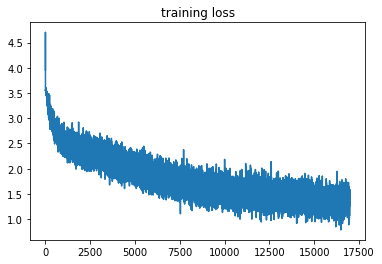

In [16]:
plt.plot(storage['losses']);
plt.title("training loss");

In [16]:
FirstLayerWeights = storage['model'].conv1.weight.detach().cpu().numpy()

In [ ]:
plot_kernels2D(FirstLayerWeights)

In [ ]:
a=FirstLayerWeights[0,0].T
plt.imshow(a)
plt.show()

In [ ]:
torch.save(storage['model'].state_dict(), PATH)